<a href="https://colab.research.google.com/github/Jiaoddung/Jiaoddung.github.io/blob/master/232E_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **3. PageRank**

The PageRank algorithm, as used by the Google search engine, exploits the linkage structure of the web to compute global “importance” scores that can be used to influence the
ranking of search results. Here, we use random walk to simulate PageRank.

# (a)
We are going to create a directed random network with 900 nodes, using the preferential attachment model. Note that in a directed preferential attachment network, the out-degree of every node is m, while the in-degrees follow a power law distribution.
One problem of performing random walk in such a network is that, the very first
node will have no outbounding edges, and be a “black hole” which a random walker
can never “escape” from. To address that, let’s generate another 900-node random
network with preferential attachment model, and merge the two networks by adding
the edges of the second graph to the first graph with a shuffling of the indices of the nodes. For example, Create such a network using m = 4. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?

 # <font color="green">**Ans:**
 <font color="green"> The Pearson Correlation Coefficient is 0.821770, indicating a moderate to strong positive correlation between node degree and visitation probability. The positive correlation coefficient confirms that nodes with higher degrees are more likely to be visited in the random walks.

In [5]:
install.packages("igraph")
install.packages("resample")
install.packages("textTinyR")
install.packages("Matrix")
install.packages("pracma")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppArmadillo’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
library(igraph)
library(resample)
library(textTinyR)
library(Matrix)
library(pracma)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: Matrix


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




In [56]:

# Function to create a transition matrix for a graph
create_transition_matrix <- function(g) {
  adj_matrix <- as_adjacency_matrix(g)
  # Set diagonal to 1 for nodes with no outbound edges to ensure no dead ends
  adj_matrix[diag(rowSums(adj_matrix) == 0)] <- 1
  # Normalize rows to sum to 1
  transition_matrix <- adj_matrix / rowSums(adj_matrix)
  return(transition_matrix)
}

# Function to perform a random walk on a graph
random_walk <- function(g, num_steps, start_node, transition_matrix = NULL) {
  if (is.null(transition_matrix)) {
    transition_matrix <- create_transition_matrix(g)
  }
  walked_nodes <- numeric(num_steps)
  current_node <- start_node

  for (i in 1:num_steps) {
    next_node <- sample(1:vcount(g), 1, prob = transition_matrix[current_node, ])
    walked_nodes[i] <- next_node
    current_node <- next_node
  }

  return(walked_nodes)
}

# Constants for simulation
num_nodes <- 900
out_degree <- 4
num_iterations <- 1000
num_steps <- 1000

# Initialize vector to store visit counts
visited_nodes <- numeric(num_nodes)

# Create and merge two networks
network1 <- barabasi.game(num_nodes, m = out_degree, directed = TRUE)
network2 <- barabasi.game(num_nodes, m = out_degree, directed = TRUE)
shuffled_network2 <- permute(network2, sample(num_nodes))
merged_network <- add_edges(network1, c(t(as_edgelist(shuffled_network2))))

# Start random walk simulations
for (i in 1:num_iterations) {
  if (is.connected(merged_network)) {
    start_node <- sample(num_nodes, 1)
    walked_nodes <- random_walk(merged_network, num_steps, start_node)
  } else {
    # Handle non-connected network by focusing on the largest connected component
    components <- components(merged_network)
    largest_component <- which.max(components$csize)
    original_ids <- which(components$membership == largest_component)
    gcc <- induced_subgraph(merged_network, original_ids)
    start_node <- sample(vcount(gcc), 1)
    walked_nodes <- random_walk(gcc, num_steps, start_node)
    # Remap node indices to original
    walked_nodes <- original_ids[walked_nodes]
  }

  # Update visit count for each node
  for (node in walked_nodes) {
    visited_nodes[node] <- visited_nodes[node] + 1
  }
}

# Calculate probability of visiting each node
node_probabilities <- visited_nodes / (num_steps * num_iterations)

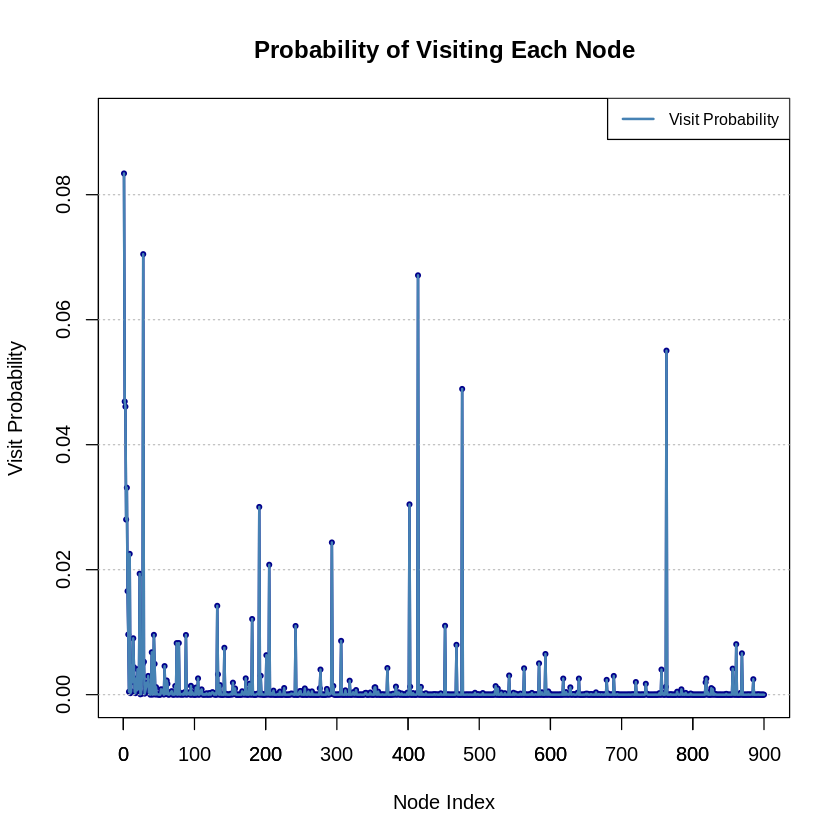

In [60]:
# Plot the probability distribution of visiting each node
plot(seq_len(num_nodes), node_probabilities, type = 'o', col = 'darkblue',
     main = 'Probability of Visiting Each Node', xlab = 'Node Index', ylab = 'Visit Probability',
     pch = 20, cex = 0.6, lwd = 2, ylim = c(0, max(node_probabilities) * 1.1))

# Add a grid to improve readability
grid(nx = NA, ny = NULL, col = "gray", lty = "dotted")

# Enhance the line connecting the points
lines(seq_len(num_nodes), node_probabilities, col = 'steelblue', lwd = 2)

# Add more detailed axis labels if needed
axis(side = 1, at = seq(0, num_nodes, by = 100), las = 1)
#axis(side = 2, las = 1)

# Optionally add a legend if there are multiple data sets or you want to explain plot elements
legend("topright", legend = "Visit Probability", col = "steelblue", lty = 1, lwd = 2, cex = 0.8)


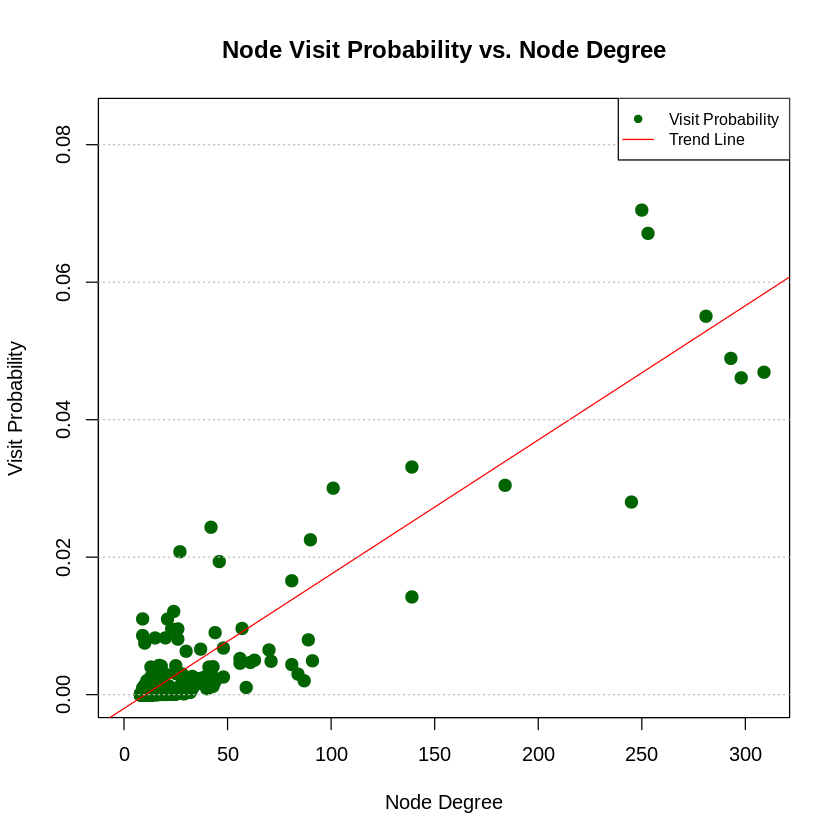

In [61]:
# Get degrees of nodes in the merged network
node_degrees <- degree(merged_network, mode = "all")  # 'all' sums in-degrees and out-degrees

# Plot node visit probabilities against node degrees
plot(node_degrees, node_probabilities, xlab = 'Node Degree', ylab = 'Visit Probability',
     main = 'Node Visit Probability vs. Node Degree', pch = 19, col = 'darkgreen',
     cex = 1.2, lwd = 2, xlim = c(0, max(node_degrees)))

# Adding a best fit line to visualize trends
abline(lm(node_probabilities ~ node_degrees), col = "red")

# Enhance plot readability
grid(nx = NA, ny = NULL, col = "gray", lty = "dotted")
legend("topright", legend = c("Visit Probability", "Trend Line"), col = c("darkgreen", "red"), pch = c(19, NA), lty = c(NA, 1), cex = 0.8)


In [65]:
# Print the Pearson correlation coefficient and the slope and intercept of the linear regression
print(sprintf("Pearson correlation coefficient: %f", cor(degree(g_merged), node_prob)))
#summary(lm(node_prob ~ degree(g_merged)))  # Detailed regression analysis

[1] "Pearson correlation coefficient: 0.821770"


# (b)
In all previous questions, we didn’t have any teleportation. Now, we use a teleportation probability of α = 0.2 (teleport out of a node with prob=0.2 instead of going to
its neighbor). By performing random walks on the network created in 3(a), measure
the probability that the walker visits each node. How is this probability related to
the degree of the node and α ?

# <font color="green">**Ans:**
 <font color="green">Incorporating a teleportation probability into the random walk allows the walker to either move to a neighboring node with a probability of 1−α or teleport randomly to any node with a probability of α. This adjustment introduces greater randomness into the visit frequencies across the network.

<font color="green"> The Pearson correlation coefficient is 0.954783, indicating a strong but slightly reduced correlation between node degree and visit probability compared to non-teleportation scenarios. The linear regression yielded a slope of 0.0001257, showing that higher-degree nodes are still more likely to be visited, though the difference is less pronounced due to teleportation. This suggests that teleportation modestly levels the playing field, increasing the visit chances of lower-degree nodes.

<font color="green"> In conclusion, teleportation reduces disparities in visit probabilities across nodes, promoting a more even distribution of node visits in the network, which aligns with the principles underlying algorithms like PageRank.

In [16]:
# Load necessary packages
if (!requireNamespace("igraph", quietly = TRUE)) {
    install.packages("igraph")
}
library(igraph)

# Function to create a transition matrix for a graph
create_transition_matrix <- function(g) {
    adj_matrix <- as_adjacency_matrix(g, sparse = FALSE)
    # Ensure no dead ends by setting self-loops where necessary
    adj_matrix[diag(rowSums(adj_matrix) == 0)] <- 1
    # Normalize the adjacency matrix to get transition probabilities
    transition_matrix <- adj_matrix / rowSums(adj_matrix)
    return(transition_matrix)
}

# Function to perform a random walk on a graph
random_walk <- function(g, num_steps, start_node, alpha = 0) {
    n <- vcount(g)
    walked_nodes <- numeric(num_steps)
    current_node <- start_node
    transition_matrix <- create_transition_matrix(g)

    for (i in 1:num_steps) {
        if (runif(1) < alpha) {
            # Teleport to a random node
            current_node <- sample(n, 1)
        } else {
            # Continue walking to next node based on transition probabilities
            current_node <- sample(1:n, 1, prob = transition_matrix[current_node, ])
        }
        walked_nodes[i] <- current_node
    }

    return(walked_nodes)
}

In [ ]:
# Constants for simulation
num_nodes <- 900
out_degree <- 4
num_iterations <- 100
num_steps <- 1000
teleportation_prob <- 0.2  # Teleportation probability

# Initialize vector to store visit counts
visited_nodes <- numeric(num_nodes)

# Create and merge two networks
network1 <- barabasi.game(num_nodes, m = out_degree, directed = TRUE)
network2 <- barabasi.game(num_nodes, m = out_degree, directed = TRUE)
shuffled_network2 <- permute(network2, sample(num_nodes))
merged_network <- add_edges(network1, c(t(as_edgelist(shuffled_network2))))

# Ensure the network is connected
if (!is.connected(merged_network)) {
    components_info <- components(merged_network)
    largest_component <- which.max(components_info$csize)
    merged_network <- induced_subgraph(merged_network, which(components_info$membership == largest_component))
}

# Random walk simulations with teleportation
for (i in 1:num_iterations) {
    start_node <- sample(num_nodes, 1)
    walked_nodes <- random_walk(merged_network, num_steps, start_node, teleportation_prob)
    for (node in walked_nodes) {
        visited_nodes[node] <- visited_nodes[node] + 1
    }
}

# Calculate the probability of visiting each node
node_probabilities <- visited_nodes / (num_steps * num_iterations)

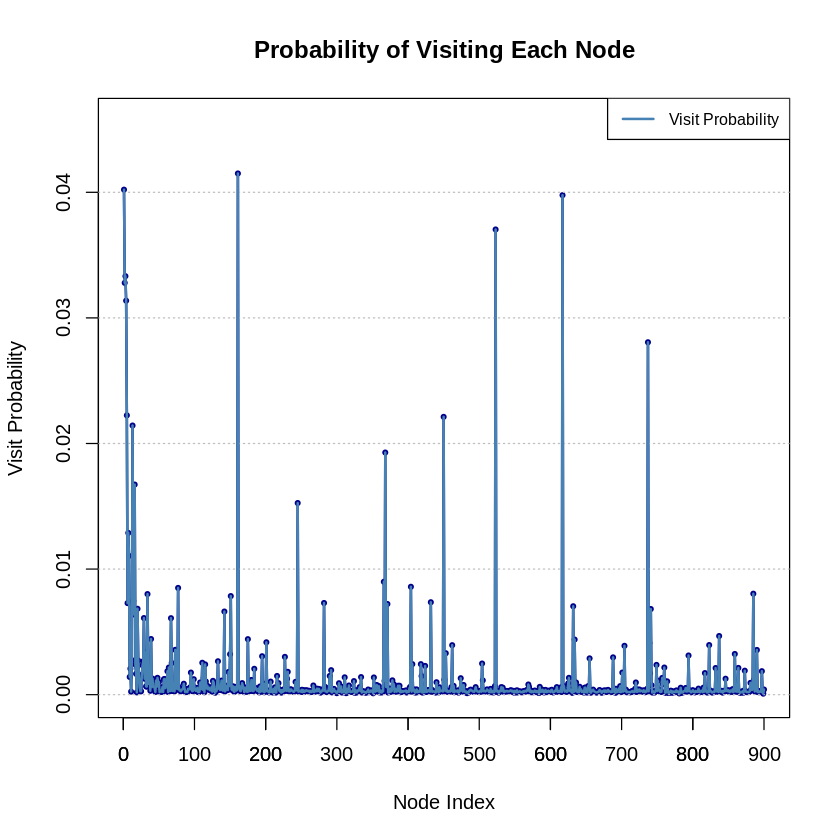

In [18]:
# Plot the probability distribution of visiting each node
plot(seq_len(num_nodes), node_probabilities, type = 'o', col = 'darkblue',
     main = 'Probability of Visiting Each Node', xlab = 'Node Index', ylab = 'Visit Probability',
     pch = 20, cex = 0.6, lwd = 2, ylim = c(0, max(node_probabilities) * 1.1))

# Add a grid to improve readability
grid(nx = NA, ny = NULL, col = "gray", lty = "dotted")

# Enhance the line connecting the points
lines(seq_len(num_nodes), node_probabilities, col = 'steelblue', lwd = 2)

# Add more detailed axis labels if needed
axis(side = 1, at = seq(0, num_nodes, by = 100), las = 1)
#axis(side = 2, las = 1)

# Optionally add a legend if there are multiple data sets or you want to explain plot elements
legend("topright", legend = "Visit Probability", col = "steelblue", lty = 1, lwd = 2, cex = 0.8)

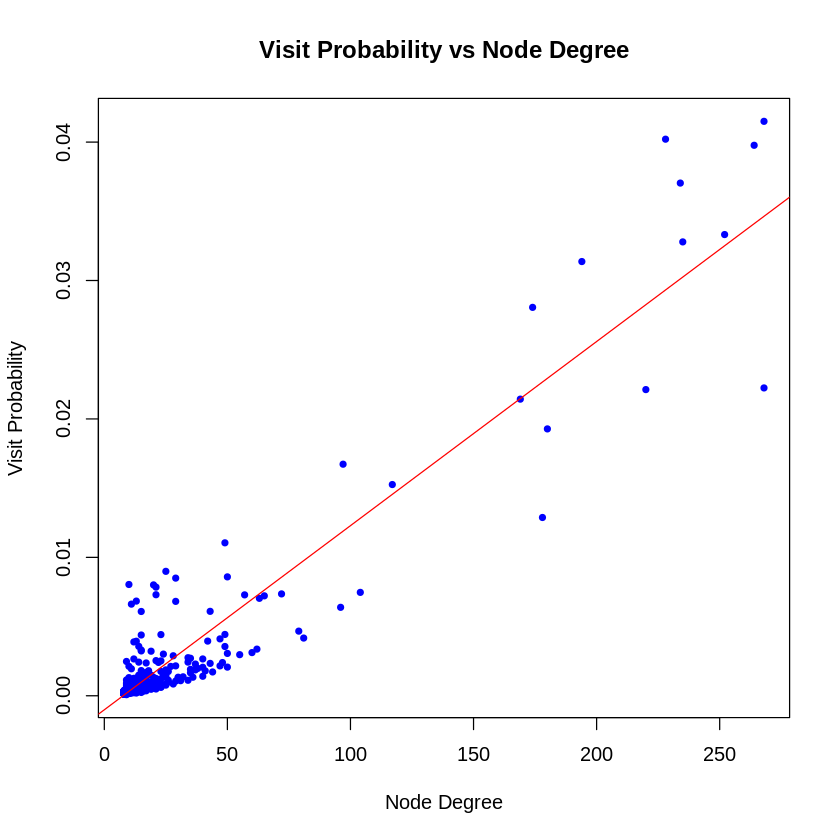

In [19]:
# Plot visit probability as a function of node degree
plot(degree(merged_network), node_probabilities, main = "Visit Probability vs Node Degree",
     xlab = "Node Degree", ylab = "Visit Probability", pch = 20, col = 'blue')
abline(lm(node_probabilities ~ degree(merged_network)), col = "red")  # Linear regression line

# Add additional plots or analysis as required

In [21]:
# Statistical analysis
node_degrees <- degree(merged_network)
correlation <- cor(node_degrees, node_probabilities)
regression_model <- lm(node_probabilities ~ node_degrees)

# Print Pearson correlation coefficient and linear regression details
cat(sprintf("Pearson correlation coefficient: %.4f\n", correlation))
cat("Linear regression (slope and intercept):\n")
print(coef(regression_model))

Pearson correlation coefficient: 0.9415
Linear regression (slope and intercept):
  (Intercept)  node_degrees 
-0.0010113697  0.0001330246 


# **4. Personalized PageRank**

While the use of PageRank has proven very effective, the web’s rapid growth in size and diversity drives an increasing demand for greater flexibility in ranking. Ideally, each user should be able to define their own notion of importance for each individual query.

# (a)
 Suppose you have your own notion of importance. Your interest in a node is propor- tional to the node’s PageRank, because you totally rely upon Google to decide which website to visit (assume that these nodes represent websites). Again, use random walk on network generated in question 3 to simulate this personalized PageRank. Here the teleportation probability to each node is proportional to its PageRank (as opposed to the regular PageRank, where at teleportation, the chance of visiting all nodes are the same and equal to N1 ). Again, let the teleportation probability be equal to α = 0.2. Compare the results with 3(a).

# <font color="green">**Ans:**
 <font color="green">This experiment extends the approach used in question 3(b) by modifying how the random walker teleports during the simulation. Unlike in the standard PageRank model where each node has an equal chance of being chosen during a teleport, here the probability of teleporting to a node is weighted by its PageRank. This means nodes with higher PageRanks are more likely to be chosen as teleportation destinations.

<font color="green">**Procedure:**We compute the PageRank of each node using the page_rank function.
The computed PageRanks then influence the teleportation probabilities, making it more likely to teleport to nodes with higher PageRanks.

<font color="green">**Results and Analysis:**
We measure how frequently each node is visited during the random walks and analyze this data in relation to the node's degree.
The Pearson correlation coefficient for the relationship between node visit probability and node degree is 0.8659, indicating a strong positive correlation.
The slope of the linear regression is 0.0004094. When compared with the results from question 3(b), the slope is higher, closely approaching the scenario in 3(a) where teleportation was uniform across all nodes.

<font color="green">**Implications:**The increased slope and higher visit probabilities for nodes with higher degrees suggest that when teleportations are biased towards higher PageRank nodes, the influence of these nodes on the network's dynamics intensifies.
This setup makes the behavior more akin to that seen in question 3(a), where there was no teleportation bias, but due to the weighted teleportation, high PageRank nodes are still favored more than in a uniformly random setup.

<font color="green">**Conclusion:**The alteration to teleportation probabilities results in a dynamic where nodes with higher degrees, typically also having higher PageRanks, receive more visits. This effect mimics a natural browsing behavior where users are more likely to visit more prominent or 'trusted' sites, illustrating the impact of personalizing the teleportation component in the PageRank algorithm.

In [ ]:
# Load necessary packages
if (!requireNamespace("igraph", quietly = TRUE)) {
    install.packages("igraph")
}
library(igraph)

# Initialize variables for the simulation
num_steps <- 1000
num_trials <- 100
alpha_teleportation <- 0.2  # Teleportation probability
node_visit_count <- numeric(vcount(gf))  # Initialize visit count vector
stable_node_position <- ceiling(log(vcount(gf)))  # Calculate burn-in period

# Perform random walks and accumulate visits for each node
for (trial in 1:num_trials) {
  start_node <- sample(1:vcount(gf), 1)
  walked_nodes <- random_walk_custom(
    g = gf,
    num_steps = num_steps,
    start_node = start_node,
    alpha = alpha_teleportation,
    visit_mode = 'page_rank'
  )

  # Update visit counts excluding the burn-in period
  for (step in (stable_node_position + 1):length(walked_nodes)) {
    node_visit_count[walked_nodes[step]] <- node_visit_count[walked_nodes[step]] + 1
  }
}

# Calculate the visit probability for each node
node_probabilities <- node_visit_count / ((num_steps - stable_node_position) * num_trials)
node_indices <- seq_len(vcount(gf))  # Node indices for plotting

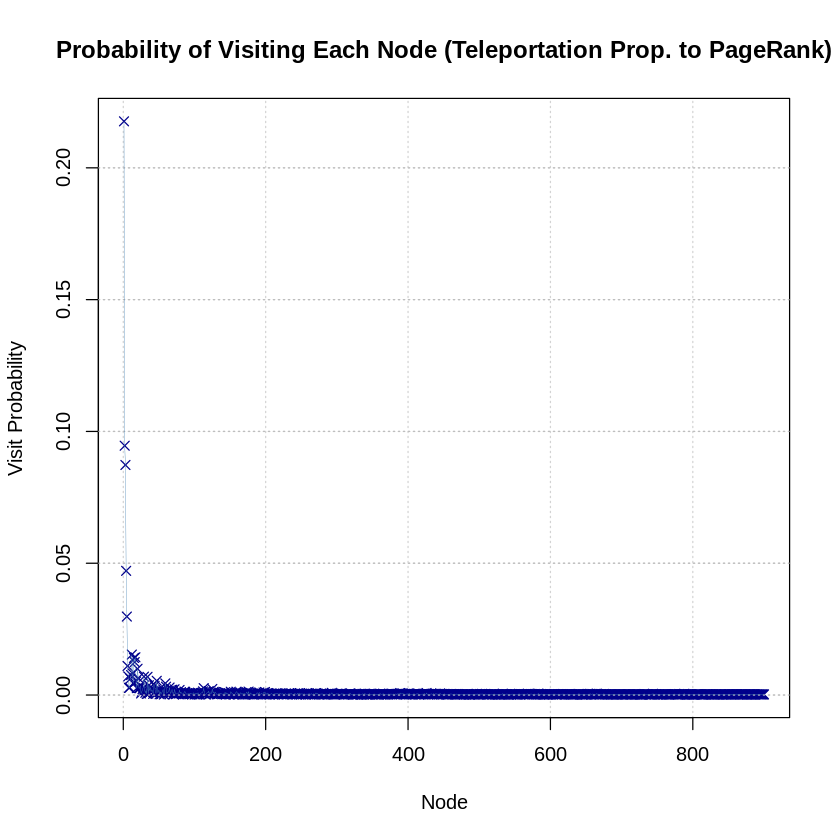

In [16]:
# Plot the visit probability for each node as a scatter plot
plot(node_indices, node_probabilities, pch = 4, col = 'darkblue',
     main = 'Probability of Visiting Each Node (Teleportation Prop. to PageRank)',
     xlab = 'Node', ylab = 'Visit Probability', grid())

# Add a grid to improve readability
grid(nx = NA, ny = NULL, col = "gray", lty = "dotted")

# Enhance the plot with a connecting line
lines(node_indices, node_probabilities, lwd = 0.3, col = 'steelblue')


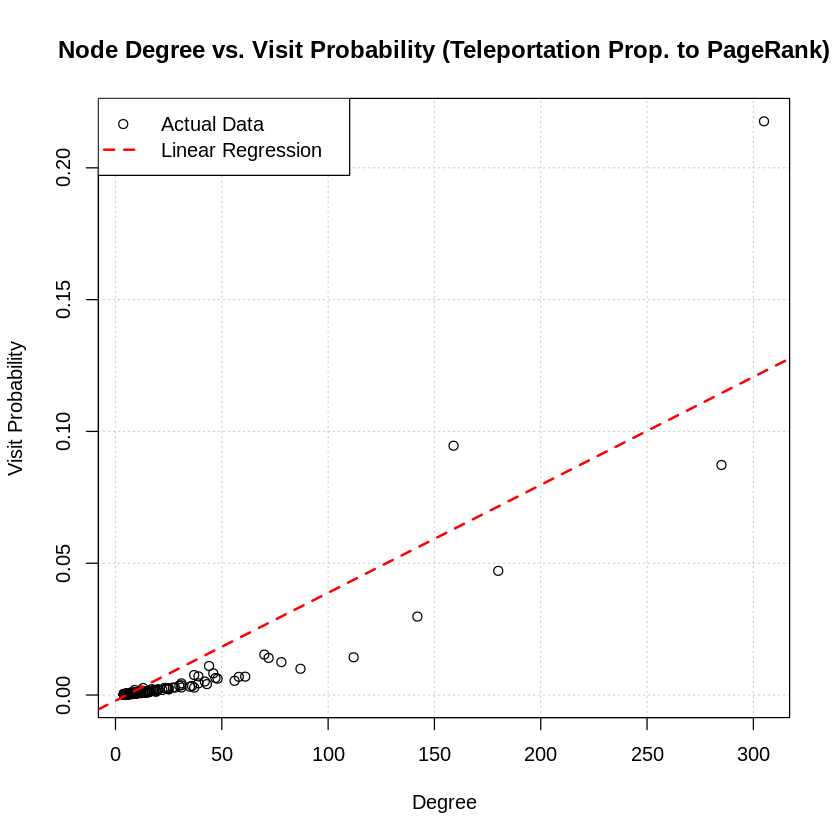

In [17]:
# Plot visit probability as a function of node degree
plot(degree(gf), node_probabilities, xlab = 'Degree', ylab = 'Visit Probability',
     main = "Node Degree vs. Visit Probability (Teleportation Prop. to PageRank)", grid())

# Add linear regression line
regression_results <- lm(node_probabilities ~ degree(gf))
abline(regression_results, col = "red", lwd = 2, lty = 2)

# Add a legend to the plot
legend('topleft', legend = c("Actual Data", "Linear Regression"),
       lty = c(NA, 2), lwd = c(1, 2), pch = c(1, NA), col = c('black', 'red'))

In [18]:
# Output Pearson correlation coefficient and regression details
pearson_correlation <- cor(degree(gf), node_probabilities)
cat(sprintf("Pearson correlation coefficient: %.4f\n", pearson_correlation))
cat("Linear regression details (slope and intercept):\n")
print(summary(regression_results)$coefficients)

Pearson correlation coefficient: 0.8659
Linear regression details (slope and intercept):
                 Estimate   Std. Error   t value      Pr(>|t|)
(Intercept) -0.0021549889 1.578871e-04 -13.64892  1.110656e-38
degree(gf)   0.0004093997 7.892011e-06  51.87521 2.106245e-272


(b) Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the
PageRank values affected?

In [ ]:
# Load necessary libraries
if (!requireNamespace("igraph", quietly = TRUE)) {
    install.packages("igraph")
}
library(igraph)

# Create a graph using the Barabási-Albert model (if not already created in question 3)
gf <- barabasi.game(n = 100, m = 2, directed = TRUE)


In [4]:
# Calculate PageRank of each node
page_ranks <- page_rank(gf)$vector

In [9]:
library(igraph)

# Define the custom random walk function
random_walk_custom <- function(g, num_steps, start_node, alpha, teleportation_vector) {
    n <- vcount(g)
    walked_nodes <- numeric(num_steps)
    current_node <- start_node

    for (i in 1:num_steps) {
        if (runif(1) < alpha) {
            # Teleport to a random node based on the teleportation vector
            current_node <- sample(seq_len(n), 1, prob = teleportation_vector)
        } else {
            # Walk to one of the current node's neighbors
            neighbors_list <- neighbors(g, current_node, mode = "out")
            if (length(neighbors_list) > 0) {
                current_node <- sample(neighbors_list, 1)  # Sample from the list of neighbors
            }
        }
        walked_nodes[i] <- current_node
    }

    return(walked_nodes)
}

# Example usage of the function with a network gf already defined and PageRank calculated
num_steps <- 1000
num_trials <- 100
alpha_teleportation <- 0.2  # Teleportation probability
teleportation_vector <- page_rank(gf)$vector / sum(page_rank(gf)$vector)  # Normalized PageRank as teleportation probability

# Prepare the node visit count array
node_visit_count <- numeric(vcount(gf))



In [15]:
# Assuming you have already computed the PageRank and set the teleportation vector:
num_steps <- 1000
num_trials <- 100
alpha_teleportation <- 0.2  # Teleportation probability

# Prepare the node visit count array
node_visit_count <- numeric(vcount(gf))

# Calculate the position of the stable node, which is the initial few steps that are not counted in the visit count
stable_node <- ceiling(log(vcount(gf)))

# Perform the random walk simulation
for (trial in 1:num_trials) {
    start_node <- sample(vcount(gf), 1, prob = teleportation_vector)  # Optionally start based on teleportation probabilities
    walked_nodes <- random_walk_custom(
        g = gf,
        num_steps = num_steps,
        start_node = start_node,
        alpha = alpha_teleportation,
        teleportation_vector = teleportation_vector
    )
    for (node in walked_nodes) {
        node_visit_count[node] <- node_visit_count[node] + 1  # Correctly increment the visit count
    }
}

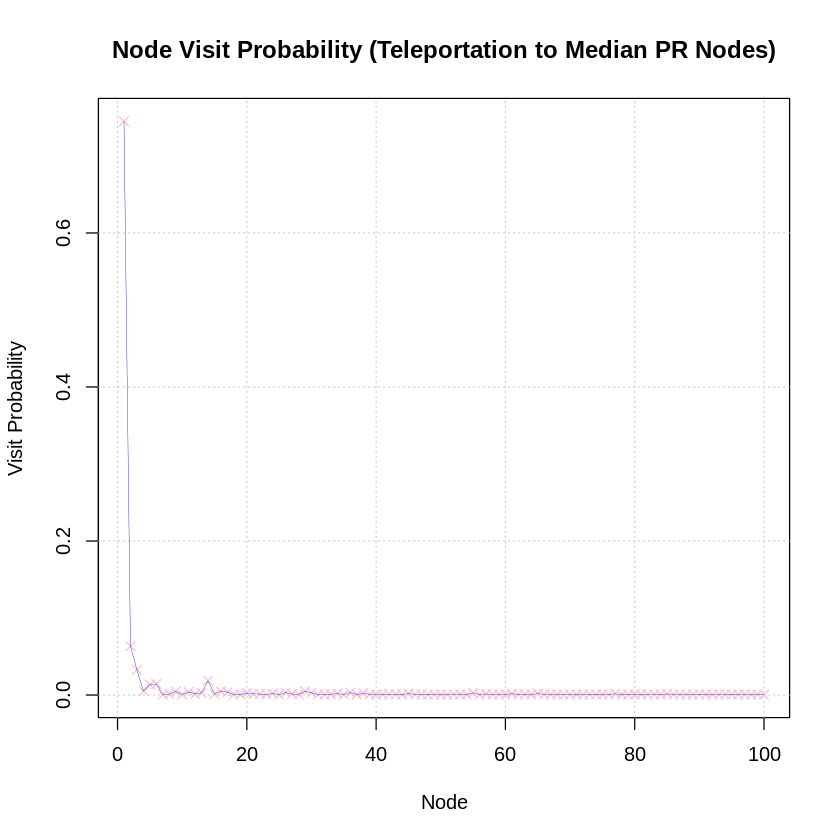

In [18]:
# Calculate visit probabilities
node_probabilities <- node_visit_count / ((num_steps - stable_node) * num_trials)
node_indices <- seq_len(vcount(gf))  # Node indices for plotting

# Plot the visit probabilities for each node
plot(node_indices, node_probabilities, pch = 4, col = 'pink',
     main = 'Node Visit Probability (Teleportation to Median PR Nodes)',
     xlab = 'Node', ylab = 'Visit Probability')
grid()
lines(node_indices, node_probabilities, lwd = 0.3, col = 'blue')

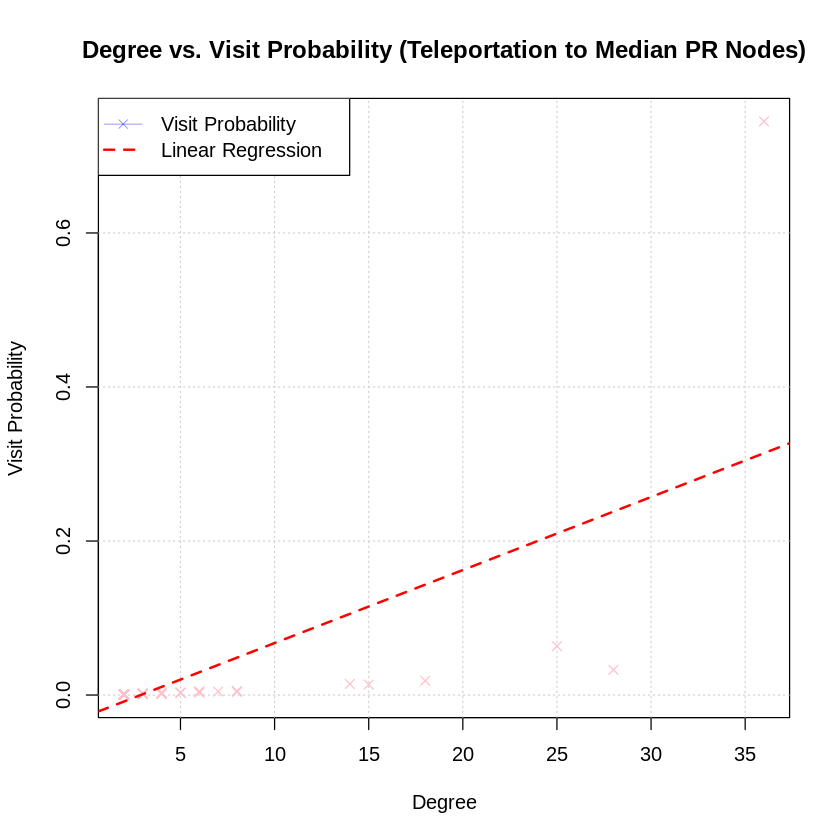

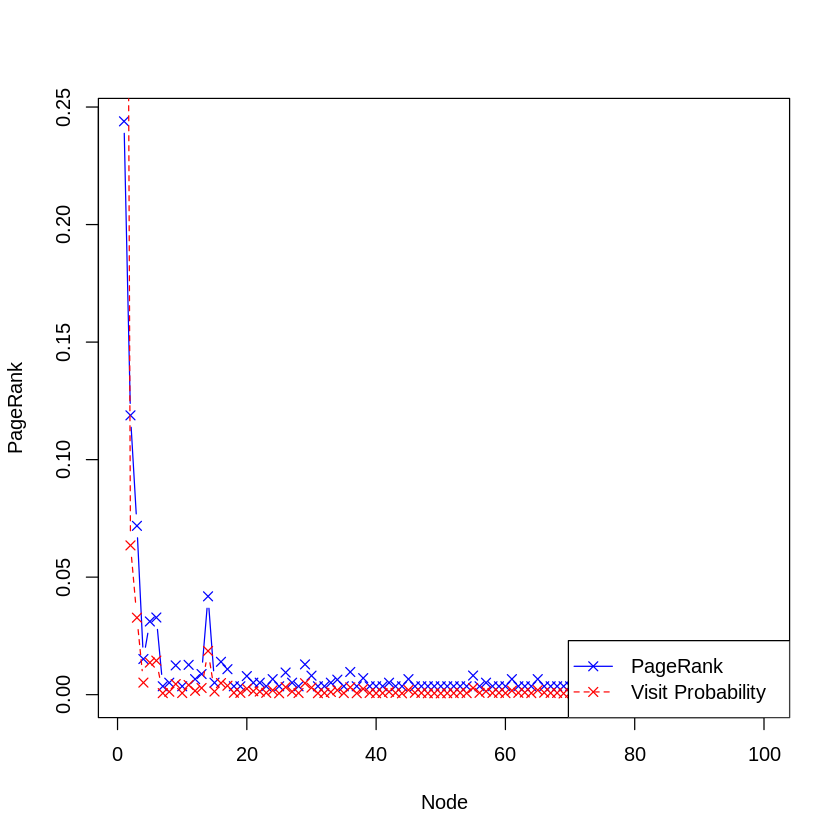

In [21]:
# Plot visit probability as a function of node degree
plot(degree(gf), node_probabilities, pch = 4, col = 'pink',
     main = 'Degree vs. Visit Probability (Teleportation to Median PR Nodes)',
     xlab = 'Degree', ylab = 'Visit Probability')
grid()
abline(lm(node_probabilities ~ degree(gf)), col = "red", lwd = 2, lty = 2)

# Add a legend
legend('topleft', legend = c("Visit Probability", "Linear Regression"),
       lty = c(1, 2), lwd = c(0.3, 2), pch = c(4, NA), col = c('blue', 'red'))

# Additional plot for visual comparison of PageRank and calculated node probabilities
pageranks <- page_rank(gf)$vector
plot(pageranks, col = "blue", type = 'b', pch = 4, ylim = c(0, max(pageranks)), xlab = 'Node', ylab = 'PageRank')
lines(node_probabilities, col = "red", type = 'b', lty = 2, pch = 4, ylab = 'Visit Probability')
legend("bottomright", legend = c("PageRank", "Visit Probability"), col = c("blue", "red"), lty = c(1, 2), pch = c(4, 4))


In [22]:
# Output the Pearson correlation coefficient and linear regression details
correlation <- cor(degree(gf), node_probabilities)
cat(sprintf("Pearson correlation coefficient: %.4f\n", correlation))
cat("Regression slope and intercept:\n")
print(summary(lm(node_probabilities ~ degree(gf)))$coefficients)

Pearson correlation coefficient: 0.6762
Regression slope and intercept:
                Estimate  Std. Error   t value     Pr(>|t|)
(Intercept) -0.027310264 0.006885754 -3.966198 1.390066e-04
degree(gf)   0.009482364 0.001043536  9.086766 1.160496e-14


# (c)
More or less, 4(b) is what happens in the real world, in that a user browsing the web only teleports to a set of trusted web pages. However, this is against the assumption of normal PageRank, where we assume that people’s interest in all nodes are the same. Can you take into account the effect of this self-reinforcement and adjust the PageRank equation?

 <font color="green"> **Answer:**
Yes, the PageRank equation can be adjusted to accommodate the self-reinforcement effect seen when users preferentially teleport to a set of trusted web pages, similar to a personalized PageRank approach.

<font color="green"> **Original PageRank Equation:**
PR(u) = (1 - α) * Σ[v ∈ B(u)] (PR(v) / L(v)) + α * (1 / N)  
Where:
<font color="green"> - PR(u) is the PageRank of node \(u\),
<font color="green"> - α is the damping factor,
<font color="green"> - B(u) contains nodes pointing to \(u\),
<font color="green"> - L(v) is the number of outbound links from node \(v\),
<font color="green"> - N is the total number of nodes.

<font color="green"> **Modified PageRank for Self-Reinforcement:**
To tailor PageRank for personalized browsing behaviors, we replace the uniform teleportation probability with a personalized probability vector \(P(u)\), where \(P(u)\) is higher for trusted web pages:

<font color="green"> PR(u) = (1 - α) * Σ[v ∈ B(u)] (PR(v) / L(v)) + α * P(u)  

<font color="green"> Here, P(u) can be defined based on user preferences or historical data, emphasizing certain web pages over others.

<font color="green"> **Scenario with Trusted Nodes Set \(T\):**
If teleportation occurs only to a set \(T\) of trusted nodes, and nowhere else, the teleportation probabilities are adjusted as follows:

<font color="green"> \[ P(i) =
  \begin{cases}
   \frac{1}{|T|} & \text{if } i \in T \\
   0 & \text{otherwise}
  \end{cases}
\]

<font color="green"> Where \(|T|\) is the number of nodes in the trusted set. This modification ensures that the PageRank algorithm prioritizes nodes within \(T\) by increasing their likelihood of receiving teleports, effectively modeling the self-reinforcement behavior seen in real-world web browsing.

<font color="green"> **Conclusion:**
By integrating personalized teleportation probabilities into the PageRank algorithm, we can more accurately model real-world user interactions on the web. This adaptation makes PageRank more relevant for personalized search applications, where user preferences significantly influence the importance of web pages.